<h1>Inteligência Artificial Preditiva: Auto ML</h1>

<p>Este notebook tem como objetivo explorar 5 principais modelos de inteligência artificial preditiva: </p>
<ol>
    <h3>Regressão</h3>
<li>Regressão Linear</li>
    <h3>Classificação</h3>
<li>Naive Bayes</li>
<li>Decision Tree: Gini</li>
<li>Decision Tree: Entropia</li>
<li>K-Nearest Neighbors (KNN)</li>
</ol>

<p>Desses 5, usaremos a que melhor performou para a base de dados que você irá inserir!
</p>

#### CODEOWNERS:
- **Rafael Cruz** [GitHub](https://github.com/RafaelBarretoCruz)
- **Gabriel Martins** [GitHub](https://github.com/GabrielOliveiraGerminare1H)
- **Fellipe Meira** [GitHub](https://github.com/fellipemeiraGerminare)



<h1> Importando bibliotecas </h1>

In [93]:
# Importações das bibliotecas gerais
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Importações dos modelos e separação de treino/teste
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Importações das métricas e pré-processamento
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    median_absolute_error,
    mean_absolute_percentage_error,
        accuracy_score,
        confusion_matrix,
        f1_score,
        ConfusionMatrixDisplay, \
        precision_score,
        recall_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Importações para visualizações
import yellowbrick.classifier as yb


# Setando opções do pandas para não diminuir o número de colunas exibidas
pd.set_option('display.max_columns', None)


<h1> Carregando a base de dados </h1>

In [94]:
# Solicita o nome do arquivo CSV ao usuário
csv_nome = input("Digite o nome do arquivo CSV (incluindo a extensão .csv): ")
caminho = os.path.join(os.getcwd(), "datasets", csv_nome)

# Detecta o delimitador automaticamente
with open(caminho, "r", encoding="utf-8") as f:
    sniffer = csv.Sniffer()
    sample = f.read(2048)
    f.seek(0)
    delimiter_encontrado = sniffer.sniff(sample).delimiter

print(f"Delimitador detectado: '{delimiter_encontrado}'")

# Carrega o arquivo CSV usando o delimitador detectado
try:
    data = pd.read_csv(caminho, delimiter=delimiter_encontrado)
    print("Arquivo carregado!")
except FileNotFoundError:
    print("Arquivo não encontrado. Verifique o nome e o caminho do arquivo.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")

Delimitador detectado: ','
Arquivo carregado!


<h1> Primeira visualização da base</h1>

In [95]:
display(data.head())

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


<h1> Definindo a coluna que será prevista (variável target)</h1>

In [96]:
# Pedindo ao usuário para definir a coluna target
coluna_target = input("Digite o nome da coluna que você deseja prever (variável target): ")

# Verificando se a coluna existe na base de dados
if coluna_target not in data.columns:
    raise ValueError(f"A coluna '{coluna_target}' não existe na base de dados.")
else:
    x = data.drop(columns=[coluna_target])
    y = data[coluna_target]

<h1> Pré-processamento dos dados </h1>

In [97]:
num_cols = x.select_dtypes(include=["int64", "float64"]).columns # Colunas númericas (contínuas)
cat_cols = x.select_dtypes(include=["object", "category"]).columns # Colunas categóricas

# Codificar categóricas
for col in cat_cols:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col].astype(str))

# Normalizar apenas se houver numéricas
if len(num_cols) > 0:
    scaler = StandardScaler()
    x[num_cols] = scaler.fit_transform(x[num_cols])

<h1> Visualizando novamente a base de dados </h1>

In [98]:
display(x.head())

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
0,0.775188,1.704176,1,1.456205,-1.249754
1,-0.383481,0.723913,0,-1.492294,-0.900982
2,1.161410,-1.063626,1,0.276805,-0.900982
3,0.002742,-1.005963,1,-0.902594,-0.900982
4,0.775188,0.320275,0,0.866505,0.145333


<h1> Separação entre treino e teste </h1>

In [99]:
x_treino, x_teste, y_treino, y_teste = train_test_split(
    x, y, test_size=0.15, random_state=42
)

<h1> Detectando o tipo da variável target para seguirmos com o modelo</h1>

In [100]:
# Se a variável target for categórica (object) ou tiver menos de 30 valores únicos, é classificação
if y.dtype == "object" or len(np.unique(y)) < 30:
    problema = "classificacao"
# Caso contrário, é regressão
else:
    problema = "regressao"

<h1> Definindo possíveis modelos </h1>

In [101]:
# Definindo os modelos a serem testados com base no tipo de problema
if problema == "classificacao":
    modelos = {
        "Decision Tree (Gini)": DecisionTreeClassifier(criterion="gini", random_state=42),
        "Decision Tree (Entropia)": DecisionTreeClassifier(criterion="entropy", random_state=42),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(),
    }
# Se for regressão, apenas Regressão Linear
else:
    modelos = {
        "Regressão Linear": LinearRegression(),
    }


<h1> Treinando e avaliando os modelos </h1>

In [102]:
resultados = {}

# Para cada modelo, treina e avalia
for nome, modelo in modelos.items():
    modelo.fit(x_treino, y_treino)
    y_pred = modelo.predict(x_teste)

    if problema == "classificacao":
        acc = accuracy_score(y_teste, y_pred)
        f1 = f1_score(y_teste, y_pred, average="weighted")
        precision = precision_score(y_teste, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_teste,y_pred, average="weighted", zero_division=0)
        resultados[nome] = {"Accuracy": acc, "F1-Score": f1, "Precision": precision, "Recall": recall}
    else:
        mse = mean_squared_error(y_teste, y_pred)
        r2 = r2_score(y_teste, y_pred)
        mae = median_absolute_error(y_teste, y_pred)
        mape = mean_absolute_percentage_error(y_teste, y_pred)

        resultados[nome] = {"MSE": mse, "R²": r2, "MAE": mae, "MAPE": mape}

<h1> Resultados dos modelos </h1>

In [103]:
display(pd.DataFrame(resultados))

# Transpondo para melhor visualização
df_resultados = pd.DataFrame(resultados).T
display(df_resultados)

# Identificar melhor modelo de classificação
if problema == "classificacao":
    melhor = df_resultados["Accuracy"].idxmax()

# Aplicando para regressão
else:
    melhor = df_resultados["R²"].idxmax()


,Regressão Linear
MSE,4.130002
R²,0.988762
MAE,1.352415
MAPE,0.034958


,MSE,R²,MAE,MAPE
Regressão Linear,4.130002,0.988762,1.352415,0.034958


<h1> Modelo campeão </h1>

In [104]:
print(f"O melhor modelo é: {melhor}")

O melhor modelo é: Regressão Linear


<h1> Mais visualizações do modelo campeão</h1>

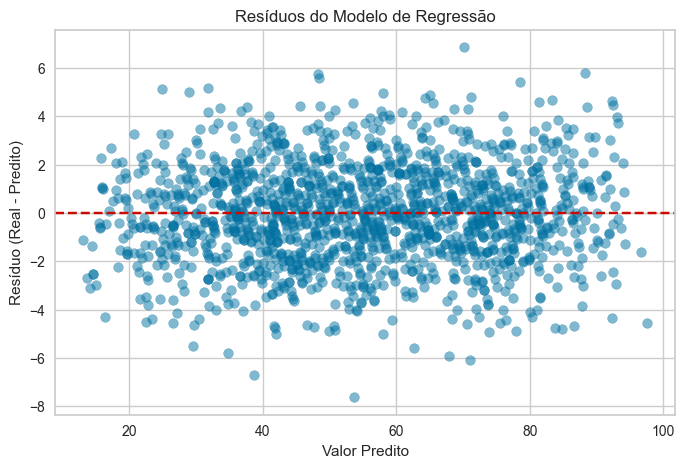

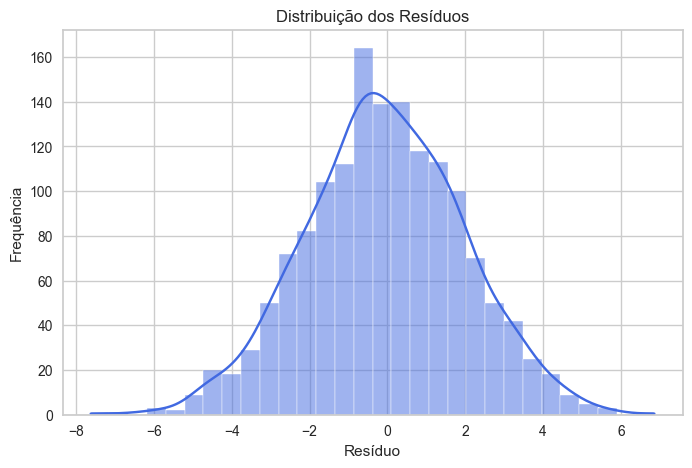

In [105]:
if problema == "classificacao":
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=df_resultados.index, y='Accuracy', data=df_resultados, palette="viridis")
    plt.ylim(0, 1.2)
    plt.title("Comparação de Acurácia dos Modelos")
    plt.ylabel("Acurácia")
    plt.xticks(rotation=45)
    # Para cada barra, adicionar o valor percentual
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{v.get_height()*100:.2f}%' for v in container])
    plt.show()

    matriz = confusion_matrix(y_teste, y_pred, labels=modelos[melhor].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=modelos[melhor].classes_)
    disp.plot(cmap=plt.cm.viridis)
    plt.grid(False)
    plt.title('Matriz de Confusão')
    plt.show()

    visualizer = yb.ClassificationReport(
                                        modelos[melhor],
                                        classes=modelos[melhor].classes_,
                                        cmap= "Greens")
    visualizer.fit(x_treino, y_treino)
    visualizer.score(x_teste, y_teste)
    visualizer.show()

else:
    residuos = y_teste - y_pred

    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuos, alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Valor Predito")
    plt.ylabel("Resíduo (Real - Predito)")
    plt.title("Resíduos do Modelo de Regressão")
    plt.show()

    # histograma
    plt.figure(figsize=(8,5))
    sns.histplot(residuos, bins=30, kde=True, color="royalblue")
    plt.title("Distribuição dos Resíduos")
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.show()